# Compute phase 2 subpopulation allele counts

In [1]:
%run imports.ipynb
%run utility_functions.ipynb
#%run setup.ipynb

2017-01-10 12:44:19.189815 :: AgamP4 reference genome not available


# Calculate allele counts :- 

In [2]:
# Phase 2
callset_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/raw/ag1000g.phase2.ar1.h5'
callset = h5py.File(callset_fn, mode='r')
callset_pass_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/pass/ag1000g.phase2.ar1.pass.h5'
callset_pass = h5py.File(callset_pass_fn, mode='r')

accessibility_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/accessibility/accessibility.h5'
accessibility = h5py.File(accessibility_fn, mode='r')

gff_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/geneset/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz'

fasta_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/genome/agamP3/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP3.fa'
genome = pyfasta.Fasta(fasta_fn, key_fn=lambda k: k.split()[0])

df_samples = pandas.read_csv('/kwiat/vector/ag1000g/release/phase2.AR1/samples/tbl_samples.txt', delimiter='\t')
samples = list(df_samples['ox_code'])
subpop_ids = sorted(df_samples.population.unique())
subpops = {pid: list(df_samples[df_samples.population == pid].index) for pid in subpop_ids}


In [3]:
subpops['all'] = list(range(len(samples)))
print([(k, len(subpops[k])) for k in subpops])

allele_counts_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/allele_counts.h5'
allele_frequencies_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/allele_frequencies.h5'
allele_frequencies_text_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/allele_frequencies.txt.gz'

[('all', 1142), ('CMgam', 297), ('FRgam', 24), ('GAgam', 69), ('BFgam', 92), ('GNcol', 4), ('KE', 48), ('GM', 65), ('UGgam', 112), ('CIcol', 71), ('AOcol', 78), ('GHcol', 55), ('GNgam', 40), ('GQgam', 9), ('GHgam', 12), ('BFcol', 75), ('GW', 91)]


# Compute subpop allele counts for autosomes - X will need male removal
- do this using the raw data set so that we have all positions if we need them
- we could also produce a pass and biallelic allele counts file?

In [4]:
list(subpops.keys())

['all',
 'CMgam',
 'FRgam',
 'GAgam',
 'BFgam',
 'GNcol',
 'KE',
 'GM',
 'UGgam',
 'CIcol',
 'AOcol',
 'GHcol',
 'GNgam',
 'GQgam',
 'GHgam',
 'BFcol',
 'GW']

In [5]:
len(subpops)

17

In [6]:
def compute_subpops_ac():
    for chrom in '2L', '2R','3L','3R':
        
        log(chrom, 'load genotypes')
        genotype = allel.GenotypeChunkedArray(callset[chrom]['calldata']['genotype'])
        
        log(chrom, 'count alleles')
        subpops_ac = genotype.count_alleles_subpops(subpops, max_allele=3)
        
        with h5py.File(allele_counts_fn, mode='a') as h5f:
            grp = h5f.require_group(chrom)
            
            for pop in list(subpops.keys()):
                grp.create_dataset(pop, data=subpops_ac[pop][:], chunks=(262144, 4), dtype='u4', compression='gzip', compression_opts=1)
        

        log(chrom, 'all done')
        
        
compute_subpops_ac()

2017-01-10 12:48:22.335862 :: 2L load genotypes
2017-01-10 12:48:22.499178 :: 2L count alleles
2017-01-10 13:04:34.761510 :: 2L all done
2017-01-10 13:04:34.763574 :: 2R load genotypes
2017-01-10 13:04:35.110813 :: 2R count alleles
2017-01-10 13:22:07.319306 :: 2R all done
2017-01-10 13:22:07.321576 :: 3L load genotypes
2017-01-10 13:22:07.431526 :: 3L count alleles
2017-01-10 13:35:50.784069 :: 3L all done
2017-01-10 13:35:50.786432 :: 3R load genotypes
2017-01-10 13:35:50.914976 :: 3R count alleles
2017-01-10 13:56:30.469162 :: 3R all done


### check that it built correctly

In [12]:
allele_counts_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/allele_counts.h5'
ac_all = h5py.File(allele_counts_fn, mode = 'r')

In [18]:
ac_tbl = allel.AlleleCountsChunkedArray(ac_all['3R']['UGgam'])
ac_tbl

,0,1,2,3
0,222,2,0,0
1,224,0,0,0
2,105,119,0,0
3,224,0,0,0
4,222,2,0,0


In [21]:
filter_pass = callset['3R/variants/FILTER_PASS'][:]
filter_pass

array([False, False, False, ..., False, False, False], dtype=bool)

In [22]:
all_pos = callset['3R/variants/POS'][:]
pos_subset = all_pos.compress(filter_pass)
ac = ac_tbl.subset(sel0 = filter_pass, sel1=None)

In [24]:
is_accessible = accessibility['3R/is_accessible'][:]
windows = allel.stats.equally_accessible_windows(is_accessible, 20000)

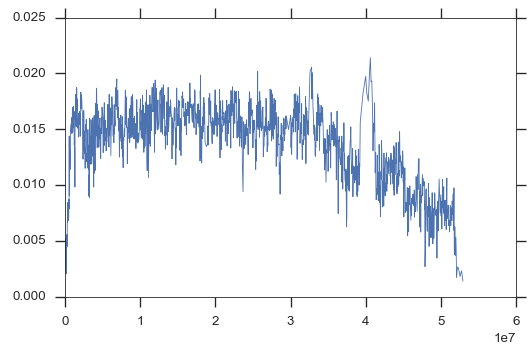

In [25]:
pi, _, _, _ = allel.stats.windowed_diversity(pos_subset, ac, windows=windows, is_accessible=is_accessible)
x = np.mean(windows, axis=1)
y = pi
plt.plot(x, y);

### now add x females

In [7]:
#get just females in data frame
df_nomales = df_samples[df_samples.sex == 'F']
len(df_nomales)

1058

In [8]:
#make dictionary of indexes per pop
subpops_nomales = {pid: list(df_nomales[df_nomales.population == pid].index) for pid in subpop_ids}
print([(k, len(subpops_nomales[k])) for k in subpops_nomales])

[('CMgam', 253), ('FRgam', 12), ('GAgam', 69), ('BFgam', 67), ('GNcol', 4), ('KE', 48), ('GM', 65), ('UGgam', 112), ('CIcol', 71), ('AOcol', 78), ('GHcol', 55), ('GNgam', 40), ('GQgam', 9), ('GHgam', 12), ('BFcol', 72), ('GW', 91)]


In [9]:
#collect the idx for all the no_males and add to dict as all:
allfem = []
for pop in list(subpops_nomales.keys()):
    for idx in subpops_nomales[pop]:
        allfem.append(idx)

allfem = sorted(allfem)
subpops_nomales['all'] = allfem

In [10]:
#check
print([(k, len(subpops_nomales[k])) for k in subpops_nomales])

[('all', 1058), ('CMgam', 253), ('FRgam', 12), ('GAgam', 69), ('BFgam', 67), ('GNcol', 4), ('KE', 48), ('GM', 65), ('UGgam', 112), ('CIcol', 71), ('AOcol', 78), ('GHcol', 55), ('GNgam', 40), ('GQgam', 9), ('GHgam', 12), ('BFcol', 72), ('GW', 91)]


In [11]:
def compute_X_subpops_ac():
    
    chrom = 'X'
    log(chrom, 'load genotypes')
    genotype = allel.GenotypeChunkedArray(callset[chrom]['calldata']['genotype'])
        
    log(chrom, 'count alleles')
    subpops_ac = genotype.count_alleles_subpops(subpops_nomales, max_allele=3)
        
    with h5py.File(allele_counts_fn, mode='a') as h5f:
        grp = h5f.require_group(chrom)
            
        for pop in list(subpops_nomales.keys()):
            grp.create_dataset(pop, data=subpops_ac[pop][:], chunks=(262144, 4), dtype='u4', compression='gzip', compression_opts=1)
        
    log(chrom, 'all done')
        
compute_X_subpops_ac()

2017-01-10 13:58:31.753436 :: X load genotypes
2017-01-10 13:58:31.955988 :: X count alleles
2017-01-10 14:04:33.872887 :: X all done


### check X built properly too!

In [29]:
ac_tbl = allel.AlleleCountsChunkedArray(ac_all['X']['UGgam'])
ac_tbl

,0,1,2,3
0,223,1,0,0
1,224,0,0,0
2,224,0,0,0
3,224,0,0,0
4,224,0,0,0


In [30]:
filter_pass = callset['X/variants/FILTER_PASS'][:]
all_pos = callset['X/variants/POS'][:]
pos_subset = all_pos.compress(filter_pass)
ac = ac_tbl.subset(sel0 = filter_pass, sel1=None)
is_accessible = accessibility['X/is_accessible'][:]
windows = allel.stats.equally_accessible_windows(is_accessible, 20000)

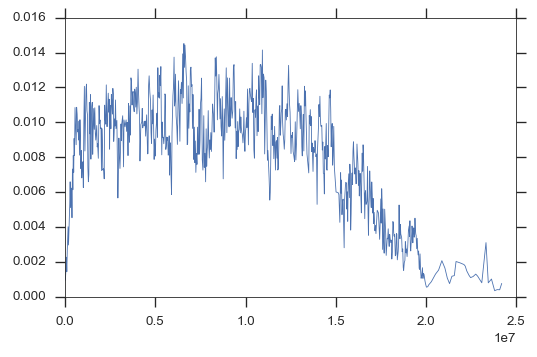

In [31]:
pi, _, _, _ = allel.stats.windowed_diversity(pos_subset, ac, windows=windows, is_accessible=is_accessible)
x = np.mean(windows, axis=1)
y = pi
plt.plot(x, y);

# NOW WHY DID WE NEED TO CHANGE dtype=u2 to u4 TO GET THIS TO WORK FOR THE BIG POPS 'cms' 'all'?

In [32]:
ac_tbl = allel.AlleleCountsChunkedArray(ac_all['3L']['CMgam'])
ac_tbl

,0,1,2,3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [33]:
#max we get
ac_tbl.max()

594

In [34]:
#max we expect
297*2

594

In [35]:
ac_tbl = allel.AlleleCountsChunkedArray(ac_all['3L']['all'])

In [36]:
ac_tbl.max()

2284

In [37]:
#all should be 2284
a = ac_tbl[:].sum(axis=1).max()
a

2284

In [38]:
#all X - should be 2 * 1058
ac_tbl = allel.AlleleCountsChunkedArray(ac_all['X']['all'])

In [39]:
a = ac_tbl[:].sum(axis=1).max()
a

2116

In [42]:
#other pops? AOM should be 156...
ac_tbl = allel.AlleleCountsChunkedArray(ac_all['3L']['AOcol'])
a = ac_tbl[:].sum(axis=1).max()
a

156

# Compute subpop allele frequencies

In [45]:
def compute_subpop_afs():
    #open the allele counts
    ach5 = h5py.File(allele_counts_fn, 'r')
    
    #open the new freq file
    with h5py.File(allele_frequencies_fn, mode='a') as h5f:
        
        for chrom in chromosomes:
            grp = h5f.require_group(chrom)
            #open the counts for a pop and a chrom
            log(chrom, 'load allele counts')
            ac = allel.AlleleCountsChunkedTable(ach5[chrom])
            
            for pop in list(subpops.keys()):
                #counts to freqs
                log(chrom, pop, 'compute allele frequencies')
                af = ac[pop].to_frequencies()
                #write to h5
                grp.create_dataset(pop, data=af[:], chunks=(262144, 4), dtype='f4', compression='gzip', compression_opts=1) 
        
    log(chrom, 'all done')
        
compute_subpop_afs()

2017-01-10 14:09:52.611712 :: 2R load allele counts
2017-01-10 14:09:52.708610 :: 2R all compute allele frequencies
2017-01-10 14:10:08.722106 :: 2R CMgam compute allele frequencies
2017-01-10 14:10:23.301962 :: 2R FRgam compute allele frequencies
2017-01-10 14:10:33.726404 :: 2R GAgam compute allele frequencies
2017-01-10 14:10:49.101028 :: 2R BFgam compute allele frequencies
2017-01-10 14:11:07.439875 :: 2R GNcol compute allele frequencies
2017-01-10 14:11:20.829067 :: 2R KE compute allele frequencies
2017-01-10 14:11:36.170874 :: 2R GM compute allele frequencies
2017-01-10 14:11:53.559731 :: 2R UGgam compute allele frequencies
2017-01-10 14:12:07.290359 :: 2R CIcol compute allele frequencies
2017-01-10 14:12:21.398246 :: 2R AOcol compute allele frequencies
2017-01-10 14:12:34.635760 :: 2R GHcol compute allele frequencies
2017-01-10 14:12:51.074294 :: 2R GNgam compute allele frequencies
2017-01-10 14:13:05.036088 :: 2R GQgam compute allele frequencies
2017-01-10 14:13:20.417646 :: 2R

# Compile text for panoptes

In [46]:
allele_frequencies = h5py.File(allele_frequencies_fn, mode='r')

In [47]:
allele_frequencies_text_fn_template = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/allele_frequencies.{chrom}.txt.gz'

In [48]:
class H5GTable(etl.Table):
    
    def __init__(self, file_path, node_path, names=None):
        self.file_path = file_path
        self.node_path = node_path
        self.names = names
        
    def __iter__(self):
        with h5py.File(self.file_path, mode='r') as h5f:
            h5g = h5f[self.node_path]
            if self.names is None:
                flds = sorted(h5g.keys())
            else:
                flds = self.names
            header = tuple(flds)
            yield header
            dsets = [h5g[n][:] for n in flds]
            log([(n, a.shape[0]) for (n, a) in zip(flds, dsets)])
            for row in zip(*dsets):
                yield tuple(row)

In [49]:
def tabulate_subpop_af(chrom, pid):
    af = allele_frequencies[chrom][pid][:]
    log(chrom, pid, af.shape[0])
    tbl = etl.wrap(af).pushheader('AF0_' + pid, 'AF1_' + pid, 'AF2_' + pid, 'AF3_' + pid)
    return tbl

In [51]:
def tabulate_af(chrom): 
    tbl = (
        H5GTable(callset_fn, '/%s/variants' % chrom, names=('CHROM', 'POS'))
        .convert('CHROM', lambda v: str(v, encoding='ascii'))
        .annex(tabulate_subpop_af(chrom, 'AOcol'))
        .annex(tabulate_subpop_af(chrom, 'BFgam'))
        .annex(tabulate_subpop_af(chrom, 'BFcol'))
        .annex(tabulate_subpop_af(chrom, 'CIcol'))
        .annex(tabulate_subpop_af(chrom, 'CMgam'))
        .annex(tabulate_subpop_af(chrom, 'FRgam'))
        .annex(tabulate_subpop_af(chrom, 'GAgam'))
        .annex(tabulate_subpop_af(chrom, 'GHgam'))
        .annex(tabulate_subpop_af(chrom, 'GHcol'))
        .annex(tabulate_subpop_af(chrom, 'GM'))
        .annex(tabulate_subpop_af(chrom, 'GNgam'))
        .annex(tabulate_subpop_af(chrom, 'GNcol'))
        .annex(tabulate_subpop_af(chrom, 'GQgam'))
        .annex(tabulate_subpop_af(chrom, 'GW'))
        .annex(tabulate_subpop_af(chrom, 'KE'))
        .annex(tabulate_subpop_af(chrom, 'UGgam'))
    )
    return tbl

In [52]:
tabulate_af('X').display()

2017-01-10 14:36:21.763589 :: X AOcol 9389639
2017-01-10 14:36:23.022588 :: X BFgam 9389639
2017-01-10 14:36:25.545548 :: X BFcol 9389639
2017-01-10 14:36:26.323365 :: X CIcol 9389639
2017-01-10 14:36:27.303555 :: X CMgam 9389639
2017-01-10 14:36:29.715061 :: X FRgam 9389639
2017-01-10 14:36:31.087941 :: X GAgam 9389639
2017-01-10 14:36:32.298793 :: X GHgam 9389639
2017-01-10 14:36:33.520409 :: X GHcol 9389639
2017-01-10 14:36:35.420770 :: X GM 9389639
2017-01-10 14:36:36.119177 :: X GNgam 9389639
2017-01-10 14:36:39.015540 :: X GNcol 9389639
2017-01-10 14:36:40.646237 :: X GQgam 9389639
2017-01-10 14:36:41.973650 :: X GW 9389639
2017-01-10 14:36:44.102398 :: X KE 9389639
2017-01-10 14:36:45.518361 :: X UGgam 9389639
2017-01-10 14:36:46.878534 :: [('CHROM', 9389639), ('POS', 9389639)]


0|CHROM,1|POS,2|AF0_AOcol,3|AF1_AOcol,4|AF2_AOcol,5|AF3_AOcol,6|AF0_BFgam,7|AF1_BFgam,8|AF2_BFgam,9|AF3_BFgam,10|AF0_BFcol,11|AF1_BFcol,12|AF2_BFcol,13|AF3_BFcol,14|AF0_CIcol,15|AF1_CIcol,16|AF2_CIcol,17|AF3_CIcol,18|AF0_CMgam,19|AF1_CMgam,20|AF2_CMgam,21|AF3_CMgam,22|AF0_FRgam,23|AF1_FRgam,24|AF2_FRgam,25|AF3_FRgam,26|AF0_GAgam,27|AF1_GAgam,28|AF2_GAgam,29|AF3_GAgam,30|AF0_GHgam,31|AF1_GHgam,32|AF2_GHgam,33|AF3_GHgam,34|AF0_GHcol,35|AF1_GHcol,36|AF2_GHcol,37|AF3_GHcol,38|AF0_GM,39|AF1_GM,40|AF2_GM,41|AF3_GM,42|AF0_GNgam,43|AF1_GNgam,44|AF2_GNgam,45|AF3_GNgam,46|AF0_GNcol,47|AF1_GNcol,48|AF2_GNcol,49|AF3_GNcol,50|AF0_GQgam,51|AF1_GQgam,52|AF2_GQgam,53|AF3_GQgam,54|AF0_GW,55|AF1_GW,56|AF2_GW,57|AF3_GW,58|AF0_KE,59|AF1_KE,60|AF2_KE,61|AF3_KE,62|AF0_UGgam,63|AF1_UGgam,64|AF2_UGgam,65|AF3_UGgam
X,23,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.995536,0.00446429,0.0,0.0
X,49,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.986111,0.0138889,0.0,0.0,0.992958,0.00704225,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.981818,0.0181818,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
X,56,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.9875,0.0125,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
X,66,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.975,0.025,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
X,67,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.998024,0.00197628,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [53]:
def write_af_text(chrom):
    tbl_fn = allele_frequencies_text_fn_template.format(chrom=chrom)
    if not os.path.exists(tbl_fn + '.md5'):
        log(chrom, 'building')
        tabulate_af(chrom).progress(200000).totsv(tbl_fn)
        !md5sum {tbl_fn} > {tbl_fn}.md5
    else:
        log(chrom, 'skipping')

In [54]:
for chrom in chromosomes:
    write_af_text(chrom)

2017-01-10 14:37:14.685746 :: 2R building
2017-01-10 14:37:18.330861 :: 2R AOcol 24767689
2017-01-10 14:37:21.989242 :: 2R BFgam 24767689
2017-01-10 14:37:25.216768 :: 2R BFcol 24767689
2017-01-10 14:37:29.151573 :: 2R CIcol 24767689
2017-01-10 14:37:32.999514 :: 2R CMgam 24767689
2017-01-10 14:37:35.812648 :: 2R FRgam 24767689
2017-01-10 14:37:39.650643 :: 2R GAgam 24767689
2017-01-10 14:37:42.905860 :: 2R GHgam 24767689
2017-01-10 14:37:46.590791 :: 2R GHcol 24767689
2017-01-10 14:37:47.995245 :: 2R GM 24767689
2017-01-10 14:37:49.516639 :: 2R GNgam 24767689
2017-01-10 14:37:50.463182 :: 2R GNcol 24767689
2017-01-10 14:37:51.518647 :: 2R GQgam 24767689
2017-01-10 14:37:52.870322 :: 2R GW 24767689
2017-01-10 14:37:54.186564 :: 2R KE 24767689
2017-01-10 14:37:55.669469 :: 2R UGgam 24767689
2017-01-10 14:38:02.858001 :: [('CHROM', 24767689), ('POS', 24767689)]
200000 rows in 60.71s (3294 row/s); batch in 60.71s (3294 row/s)
400000 rows in 122.53s (3264 row/s); batch in 61.82s (3235 row/

In [55]:
!chmod -v a-w {allele_counts_fn}

mode of `/kwiat/vector/ag1000g/release/phase2.AR1/extras/allele_counts.h5' changed from 0664 (rw-rw-r--) to 0444 (r--r--r--)


In [56]:
!chmod -v a-w {allele_frequencies_fn}

mode of `/kwiat/vector/ag1000g/release/phase2.AR1/extras/allele_frequencies.h5' changed from 0664 (rw-rw-r--) to 0444 (r--r--r--)


In [ ]:
# !md5sum {allele_counts_fn} > {allele_counts_fn}.md5
# !md5sum {allele_frequencies_fn} > {allele_frequencies_fn}.md5

In [ ]:
2+2